In [73]:
# Regular EDA
import calendar
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Feature Engineering
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Model Evaluations
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import cross_validate, cross_val_score

# Models for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
bike_train_df = pd.read_csv('./train.csv',parse_dates=True)
training_df = bike_train_df.copy()
bike_test_df = pd.read_csv('./test.csv', parse_dates=True)
testing_df = bike_test_df.copy()

In [3]:
training_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [4]:
training_df.shape

(10886, 12)

In [5]:
testing_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [6]:
testing_df.shape

(6493, 9)

In [7]:
training_df.workingday.value_counts()

1    7412
0    3474
Name: workingday, dtype: int64

In [8]:
testing_df.workingday.value_counts()

1    4453
0    2040
Name: workingday, dtype: int64

### Missing Values

In [9]:
training_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### Transforming datetime Column

In [10]:
def extract_time(df):
    
    hours = []
    month = []
    year = []
    for i in df['datetime']:
        dt_object2 = datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
        hours.append(dt_object2.hour)
        month.append(dt_object2.month)
        year.append(dt_object2.year)

    df['hours'] = pd.DataFrame(hours)
    df['hours'] = df['hours'].astype(int)
    df['day'] = pd.to_datetime(df.datetime).dt.day_name()
    df['month'] = pd.DataFrame(month)
    df['month'] = df['month'].astype(int)
    df['year'] = pd.DataFrame(year)
    df['year'] = df['year'].astype(int)
    
extract_time(training_df)
extract_time(testing_df)

In [11]:
def transformation(df):

    df.season = df.season.map({1:'Spring', 
                               2:'Summer', 
                               3:'Fall', 
                               4:'Winter'})

    df['month'] = df['month'].apply(lambda x:calendar.month_name[x])

    df.weather = df.weather.map({1:'Clear', 
                                 2:'Mist & Cloudy', 
                                 3:'Light Rain or Snow', 
                                 4:'Heavy Rain or Snow'})
    
transformation(training_df)
transformation(testing_df)

### Removing Unwanted Columns

In [12]:
training_df.duplicated().value_counts()

False    10886
dtype: int64

In [13]:
training_df.drop(columns=['casual', 'registered', 'datetime', 'atemp'], axis=1, inplace=True)
testing_df.drop(columns=['datetime', 'atemp'], axis=1, inplace=True)

### Reshuffling Columns

In [14]:
training_df = training_df.reindex(columns=['hours', 'day', 'month', 'year', 
                                           'holiday', 'workingday', 'season', 
                                           'temp','humidity', 'windspeed', 
                                           'weather', 'count'])

testing_df = testing_df.reindex(columns=['hours', 'day', 'month', 'year', 
                                         'holiday', 'workingday', 'season', 
                                         'temp', 'humidity', 'windspeed', 
                                         'weather'])

In [15]:
training_df.head(3)

,hours,day,month,year,holiday,workingday,season,temp,humidity,windspeed,weather,count
0,0,Saturday,January,2011,0,0,Spring,9.84,81,0.0,Clear,16
1,1,Saturday,January,2011,0,0,Spring,9.02,80,0.0,Clear,40
2,2,Saturday,January,2011,0,0,Spring,9.02,80,0.0,Clear,32


In [16]:
testing_df.head(3)

,hours,day,month,year,holiday,workingday,season,temp,humidity,windspeed,weather
0,0,Thursday,January,2011,0,1,Spring,10.66,56,26.0027,Clear
1,1,Thursday,January,2011,0,1,Spring,10.66,56,0.0000,Clear
2,2,Thursday,January,2011,0,1,Spring,10.66,56,0.0000,Clear


***Columns that needs to be changed to category***

In [17]:
training_df.season.value_counts()

Winter    2734
Summer    2733
Fall      2733
Spring    2686
Name: season, dtype: int64

In [18]:
training_df.weather.value_counts()

Clear                 7192
Mist & Cloudy         2834
Light Rain or Snow     859
Heavy Rain or Snow       1
Name: weather, dtype: int64

In [19]:
training_df.day.value_counts()

Saturday     1584
Sunday       1579
Thursday     1553
Monday       1551
Wednesday    1551
Tuesday      1539
Friday       1529
Name: day, dtype: int64

In [20]:
def cat_col(dfs):
    
    cat_cols = ['day', 'season', 'weather', 'month']
    
    for cols in cat_cols:
        dfs[cols] = dfs[cols].astype('category')
        
cat_col(training_df)
cat_col(testing_df)

In [21]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   hours       10886 non-null  int64   
 1   day         10886 non-null  category
 2   month       10886 non-null  category
 3   year        10886 non-null  int64   
 4   holiday     10886 non-null  int64   
 5   workingday  10886 non-null  int64   
 6   season      10886 non-null  category
 7   temp        10886 non-null  float64 
 8   humidity    10886 non-null  int64   
 9   windspeed   10886 non-null  float64 
 10  weather     10886 non-null  category
 11  count       10886 non-null  int64   
dtypes: category(4), float64(2), int64(6)
memory usage: 724.2 KB


In [22]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   hours       6493 non-null   int64   
 1   day         6493 non-null   category
 2   month       6493 non-null   category
 3   year        6493 non-null   int64   
 4   holiday     6493 non-null   int64   
 5   workingday  6493 non-null   int64   
 6   season      6493 non-null   category
 7   temp        6493 non-null   float64 
 8   humidity    6493 non-null   int64   
 9   windspeed   6493 non-null   float64 
 10  weather     6493 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 381.7 KB


In [23]:
training_df.describe()

,hours,year,holiday,workingday,temp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000
mean,11.541613,2011.501929,0.028569,0.680875,20.23086,61.886460,12.799395,191.574132
std,6.915838,0.500019,0.166599,0.466159,7.79159,19.245033,8.164537,181.144454
min,0.000000,2011.000000,0.000000,0.000000,0.82000,0.000000,0.000000,1.000000
25%,6.000000,2011.000000,0.000000,0.000000,13.94000,47.000000,7.001500,42.000000
50%,12.000000,2012.000000,0.000000,1.000000,20.50000,62.000000,12.998000,145.000000
75%,18.000000,2012.000000,0.000000,1.000000,26.24000,77.000000,16.997900,284.000000
max,23.000000,2012.000000,1.000000,1.000000,41.00000,100.000000,56.996900,977.000000


### Exploratory Data Analysis

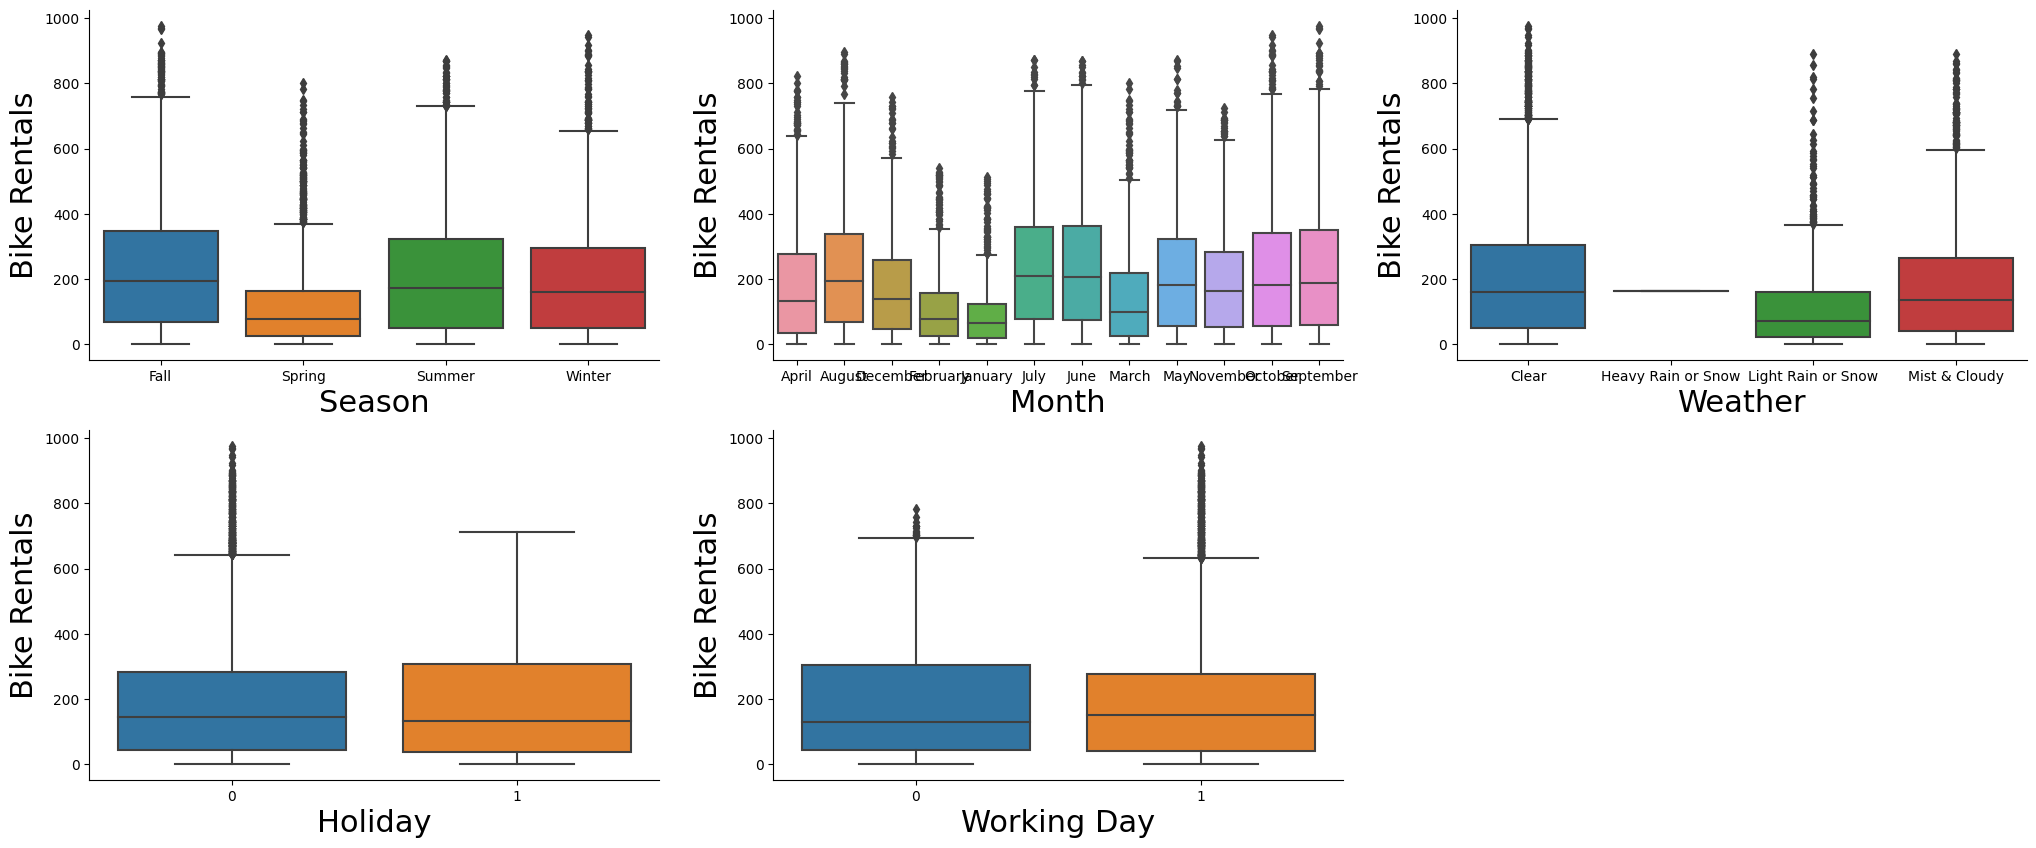

In [24]:
plt.figure(figsize=(25, 10))

plt.subplot(2,3,1)
sns.boxplot(x='season', y='count', data=training_df)
plt.xlabel('Season', fontsize=22)
plt.ylabel('Bike Rentals', fontsize=22)

plt.subplot(2,3,2)
sns.boxplot(x='month', y='count', data=training_df)
plt.xlabel('Month', fontsize=22)
plt.ylabel('Bike Rentals', fontsize=22)

plt.subplot(2,3,3)
sns.boxplot(x='weather', y='count', data=training_df)
plt.xlabel('Weather', fontsize=22)
plt.ylabel('Bike Rentals', fontsize=22)

plt.subplot(2,3,4)
sns.boxplot(x='holiday', y='count', data=training_df)
plt.xlabel('Holiday', fontsize=22)
plt.ylabel('Bike Rentals', fontsize=22)

plt.subplot(2,3,5)
sns.boxplot(x='workingday', y='count', data=training_df)
plt.xlabel('Working Day', fontsize=22)
plt.ylabel('Bike Rentals', fontsize=22)

sns.despine(top=True,bottom=False)
plt.savefig('Outliers.png', dpi=300)
plt.show()

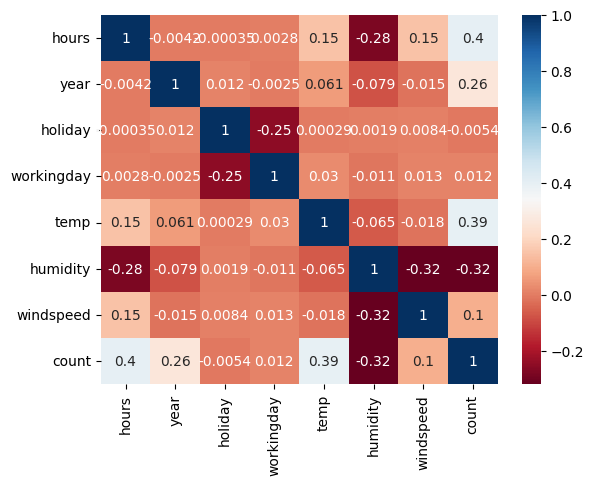

In [25]:
sns.heatmap(training_df.corr(numeric_only=True), annot=True, cmap='RdBu');
plt.savefig('Correlation.png', dpi=150)

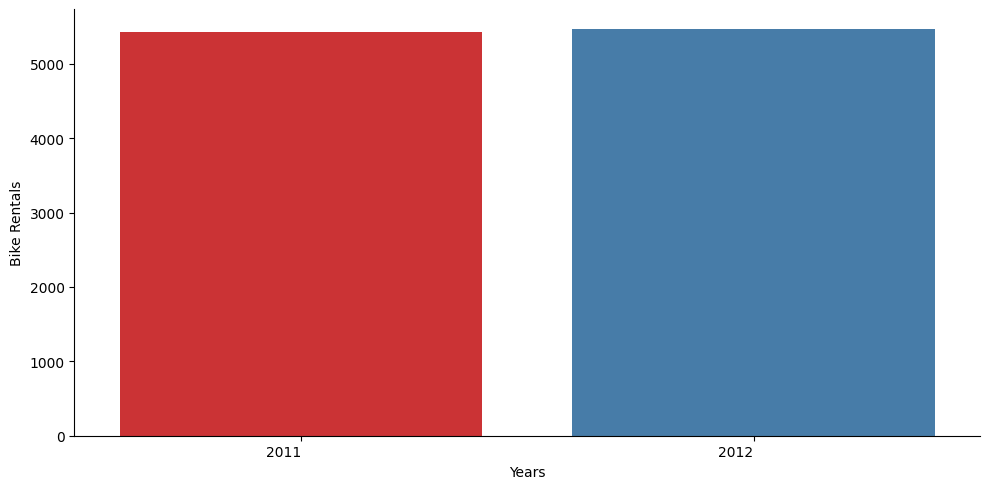

In [26]:
chart = sns.catplot(data=training_df,
                    x='year', 
                    kind='count',
                    palette='Set1',
                    aspect=2,
                    height=5)

chart.set_xticklabels(horizontalalignment='right')

plt.xlabel('Years')
plt.ylabel('Bike Rentals')
plt.savefig('Rental Statistics on Yearly Basis.png', dpi=150)
plt.show()

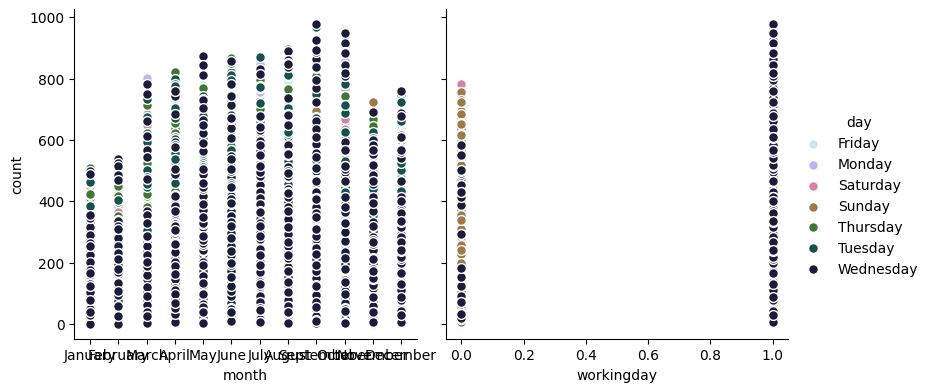

In [27]:
g = sns.PairGrid(training_df, y_vars=["count"], x_vars=["month", "workingday"], height=4, palette='cubehelix_r', hue='day')
g.map(plt.scatter, s=50, edgecolor="white")
g.add_legend()

plt.savefig('Rountine Rental Stats.png', dpi=150)
plt.show()

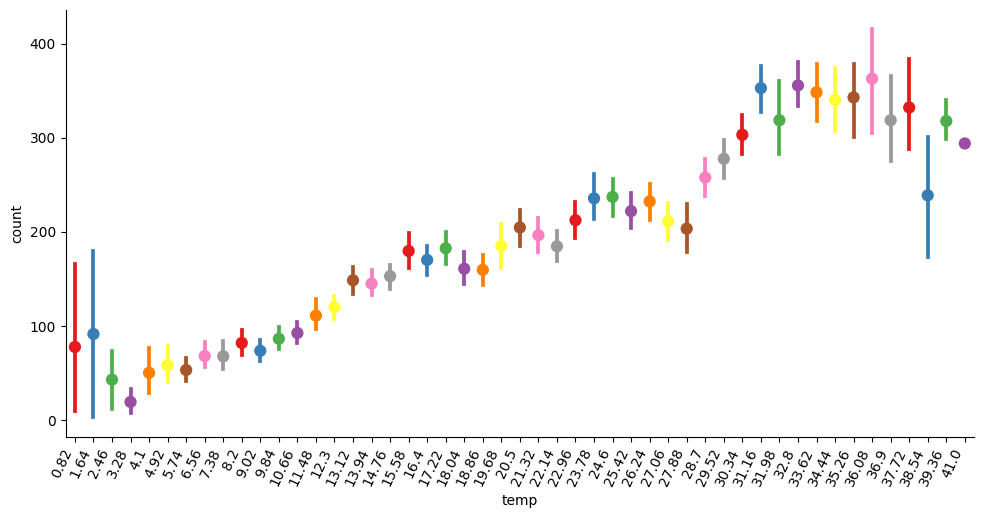

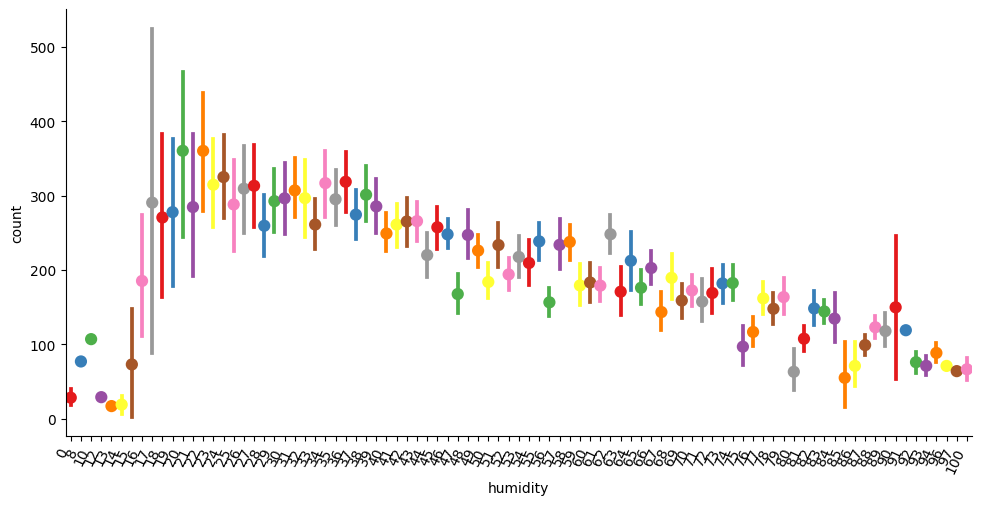

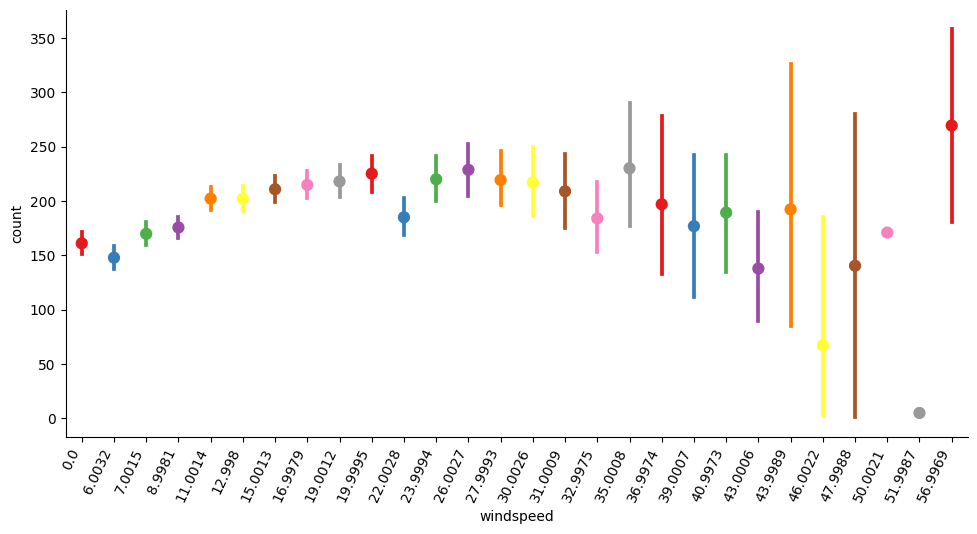

In [28]:
chart_3 = sns.catplot(data=training_df,
                    x='temp', 
                    y='count',
                    kind='point',
                    palette='Set1',
                    aspect=2,
                    height=5)
chart_3.set_xticklabels(rotation=65, horizontalalignment='right')

chart_5 = sns.catplot(data=training_df,
                    x='humidity', 
                    y='count',
                    kind='point',
                    palette='Set1',
                    aspect=2,
                    height=5)
chart_5.set_xticklabels(rotation=65, horizontalalignment='right')

chart_6 = sns.catplot(data=training_df,
                    x='windspeed', 
                    y='count',
                    kind='point',
                    palette='Set1',
                    aspect=2,
                    height=5)
chart_6.set_xticklabels(rotation=65, horizontalalignment='right')

plt.savefig('Rental Stats Based on Weather.png', dpi=300)
plt.show()

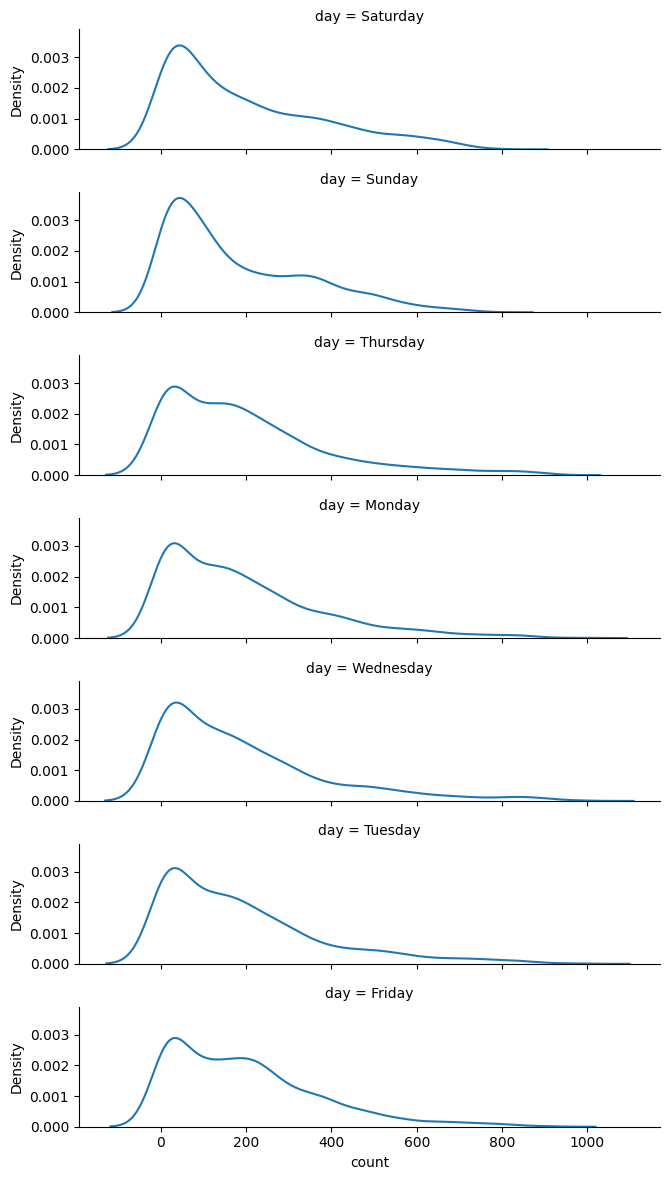

In [29]:
ordered_days = training_df.day.value_counts().index

g = sns.FacetGrid(training_df, 
                  row="day", 
                  row_order=ordered_days,
                  height=1.7, 
                  aspect=4,)
g.map(sns.kdeplot, "count")

plt.savefig('Bike Usage on Weekly Basis.png', dpi=150)
plt.show()

In [30]:
# non_working_day = training_df[((training_df['workingday'] == 0) & (training_df['holiday'] == 0)) & 
#                               ((training_df['hours'] > 10) & (training_df['hours'] < 17))]
# non_working_day

In [31]:
# working_day = training_df[((training_df['workingday'] == 1) & (training_df['holiday'] == 0)) & 
#                           ((training_df['hours'] > 8) & (training_df['hours'] <= 19))]
# working_day

### Feature Engineering


In [32]:
# working_day.tail()

In [33]:
X = training_df.drop(['count'], axis=1)
y = training_df['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7620, 11), (3266, 11), (7620,), (3266,))

***Changing Categorical Data to Numbers***

In [35]:
cat_features = ['day', 'month', 'weather', 'season']

one_hot = OneHotEncoder(handle_unknown='ignore')

transformer = ColumnTransformer([('one_hot', one_hot, cat_features)], remainder='passthrough')
transformed_X = transformer.fit_transform(X)

In [36]:
pd.DataFrame(transformed_X)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2011.0,0.0,0.0,9.84,81.0,0.0000
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,2011.0,0.0,0.0,9.02,80.0,0.0000
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,2011.0,0.0,0.0,9.02,80.0,0.0000
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.0,2011.0,0.0,0.0,9.84,75.0,0.0000
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,4.0,2011.0,0.0,0.0,9.84,75.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,19.0,2012.0,0.0,1.0,15.58,50.0,26.0027
10882,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,20.0,2012.0,0.0,1.0,14.76,57.0,15.0013
10883,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,21.0,2012.0,0.0,1.0,13.94,61.0,15.0013
10884,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,22.0,2012.0,0.0,1.0,13.94,61.0,6.0032


In [37]:
X = training_df.drop(['count'], axis=1)
y = training_df['count']

X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7620, 34), (3266, 34), (7620,), (3266,))

In [39]:
# Put models in a dictionary
models = {'Linear Regression': LinearRegression(), 
          'Linear SVR': LinearSVR(), 
          'Random Forest Regessor': RandomForestRegressor(), 
          'XGB Regressor': XGBRegressor()}

# Creating a function to fit & score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fit & Evaluate given ML models.
    models: a dict of different sklearn ML models.
    """
    # Set random seed
    np.random.seed(42)
    # Make a dict to keep model scores
    model_scores = {}
    # Loop through the models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model & append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [40]:
model_scores = fit_and_score(models = models, 
                             X_train = X_train, 
                             X_test = X_test, 
                             y_train = y_train, 
                             y_test = y_test)
model_scores

{'Linear Regression': 0.39981162518972235,
 'Linear SVR': 0.32745019142346743,
 'Random Forest Regessor': 0.9476014408429474,
 'XGB Regressor': 0.949799960381375}

### Model Comparison

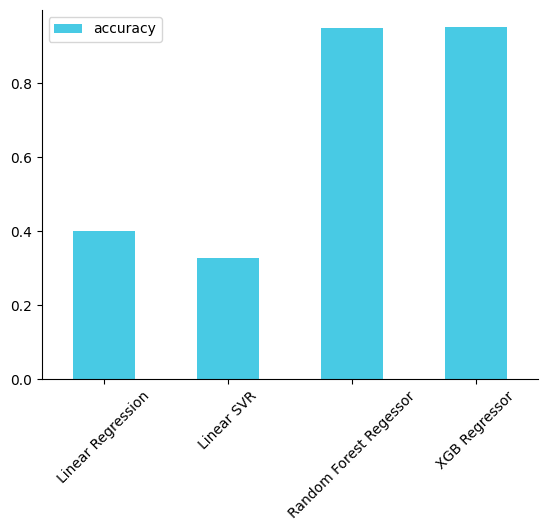

In [41]:
model_comp = pd.DataFrame(model_scores, index=['accuracy'])
model_comp.T.plot.bar(rot=45, color='#48cae4');

plt.legend(loc='upper left')
sns.despine(top=True, right=True)
plt.savefig('Model Selection.png', dpi=150)

In [53]:
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

rf_model.fit(X_train, y_train);
xgb_model.fit(X_train, y_train);

In [59]:
rf_y_preds = rf_model.predict(X_test)
print(f'Random forest y_preds:{rf_y_preds}')
xgb_y_preds = xgb_model.predict(X_test)
print(f'XGB y_preds:{xgb_y_preds}')

Random forest y_preds:[136.64  12.11 153.13 ... 222.46 187.18   1.9 ]
XGB y_preds:[101.97292     7.9722104 152.92743   ... 198.4815    175.47939
  -6.624414 ]


In [56]:
y_test

3133    127
5786     13
5224    163
8953    233
8054    222
       ... 
5527     86
7417    157
5700    281
8303    152
411       2
Name: count, Length: 3266, dtype: int64

In [62]:
true_mean = y_test.mean()
true_mean

192.04960195958358

### Model Evaluation with Random Forest Regressor

In [93]:
'R2_Score'
round(r2_score(y_test, rf_y_preds, multioutput='variance_weighted'),4)

0.9476

In [115]:
'MAE'
round(mean_absolute_error(y_test, rf_y_preds),2)

25.58

In [111]:
'MSE'
round(mean_squared_error(y_test, rf_y_preds),2)

1704.86

In [112]:
'RMSE'
round(mean_squared_error(y_test, rf_y_preds, squared=False),2)

41.29

In [117]:
'MSLE'
round(mean_squared_log_error(y_test, rf_y_preds),3)

0.111

In [135]:
'RMSLE'
round(mean_squared_log_error(y_test, rf_y_preds, squared=False),3)

0.333

Hyperparameters not used because they were taking alot of time on cpu.
### Cross Validation with Random Forest Regressor

In [132]:
def scoring_params(y_true, y_pred):
    
    scoring = {'R2_Score': r2_score(y_true, y_pred, multioutput='variance_weighted'), 
           'MAE': mean_absolute_error(y_true, y_pred), 
           'MSE': mean_squared_error(y_true, y_pred), 
           'RMSE': mean_squared_error(y_true, y_pred, squared=False)}
    
rf_scoring_params = scoring_params(y_test, rf_y_preds)
xgb_scoring_params = scoring_params(y_test, xgb_y_preds)

In [133]:
cv_score = cross_validate(rf_model, 
                          transformed_X, y, cv=5, 
                          scoring=rf_scoring_params, 
                          n_jobs=-1, 
                          verbose=True)

rf_df_cv = pd.DataFrame(cv_score)
rf_df_cv

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


,fit_time,score_time,test_score
0,3.331676,0.034774,0.305829
1,3.217221,0.030908,0.879897
2,3.313339,0.037192,0.581021
3,4.082600,0.034290,0.879464
4,4.118716,0.043536,0.866537


### Model Evaluation with XGB Regressor

In [107]:
'R2_Score'
round(r2_score(y_test, xgb_y_preds, multioutput='variance_weighted'),4)

0.9498

In [114]:
'MAE'
round(mean_absolute_error(y_test, xgb_y_preds),2)

25.87

In [110]:
'MSE'
round(mean_squared_error(y_test, xgb_y_preds),4)

1633.5241

In [118]:
'RMSE'
round(mean_squared_error(y_test, xgb_y_preds, squared=False),2)

40.42

### Cross Validation with XGB Regressor

In [136]:
cv_score = cross_validate(xgb_model, 
                          transformed_X, y, cv=5, 
                          scoring=xgb_scoring_params, 
                          n_jobs=-1, 
                          verbose=True)

xgb_df_cv = pd.DataFrame(cv_score)
xgb_df_cv

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


,fit_time,score_time,test_score
0,1.477427,0.009228,0.369800
1,1.505430,0.012785,0.877065
2,1.910891,0.006634,0.785541
3,1.490073,0.012261,0.899213
4,1.904128,0.007644,0.892008


* Feature Importance
* Testing